In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import procrustes
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import NearestNeighbors
import anndata as ad

In [2]:
data_folder = '/scratch/ssarnata/persist_project/sc_data_baptiste'

adata_11_1 = sc.read_10x_mtx('%s/filtered_feature_bc_matrix_111' %data_folder, var_names = 'gene_symbols', cache = True)
adata_6_3 = sc.read_10x_mtx('%s/filtered_feature_bc_matrix_63' %data_folder, var_names = 'gene_symbols', cache = True)
adata_8_1 = sc.read_10x_mtx('%s/filtered_feature_bc_matrix_81' %data_folder, var_names = 'gene_symbols', cache = True)

adata_6_3.obs['sample'] = '6_3'
adata_8_1.obs['sample'] = '8_1'
adata_11_1.obs['sample'] = '11_1'

adata_6_3.var_names_make_unique()
adata_8_1.var_names_make_unique()
adata_11_1.var_names_make_unique()

adata = ad.concat([adata_6_3, adata_8_1, adata_11_1])

# adata = adata_11_1.copy()

/projects/users/ssarnata/envs/persist/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [3]:
## Gene panels
panels_path = '/scratch/ssarnata/persist_project/sc_data_baptiste/analysis_output/persist_unsupervised_results_new_data_Baptiste_different_panels.tsv'
panels = pd.read_csv(panels_path, sep='\t', index_col=0)


In [4]:
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=10000)
sc.pp.filter_cells(adata, min_genes=200) 
sc.pp.filter_genes(adata, min_cells=3)
adata = adata[:, adata.var.highly_variable].copy()
sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack', n_comps=30)
full_pca = adata.obsm['X_pca']

In [5]:
gene_panels = {
    int(col.split("_")[-1]): panels.index[panels[col]].tolist()
    for col in panels.columns if col.startswith("persist_set_")
}

In [1]:
# for panel_size, genes in gene_panels.items():
#     print(panel_size, genes)

In [7]:
results = []

for panel_size, genes in gene_panels.items():
    print(f"Evaluating panel of size {panel_size}")
    genes_present = [gene for gene in genes if gene in adata.var_names]
    print(f"Number of genes present in panel: {len(genes_present)}")
    ad = adata[:, genes_present].copy()
    sc.pp.scale(ad)
    sc.tl.pca(ad, svd_solver='arpack', n_comps=30)
    panel_pca = ad.obsm['X_pca']

    # KNN preservation
    k = 15
    nn_full = NearestNeighbors(n_neighbors=k).fit(full_pca).kneighbors(return_distance=False)
    nn_panel = NearestNeighbors(n_neighbors=k).fit(panel_pca).kneighbors(return_distance=False)
    knn_overlap = np.mean([len(set(nn_full[i]) & set(nn_panel[i])) / k for i in range(full_pca.shape[0])])

    # Distance correlation
    dist_full = squareform(pdist(full_pca, metric='euclidean'))
    dist_panel = squareform(pdist(panel_pca, metric='euclidean'))
    triu_idx = np.triu_indices_from(dist_full, k=1)
    spearman_corr = np.corrcoef(dist_full[triu_idx], dist_panel[triu_idx])[0, 1]

    # Procrustes UMAP similarity
    sc.pp.neighbors(ad, use_rep='X_pca')
    sc.tl.umap(ad)
    sc.pp.neighbors(adata, use_rep='X_pca')  # reuse full data
    sc.tl.umap(adata)

    _, _, disparity = procrustes(adata.obsm['X_umap'], ad.obsm['X_umap'])
    results.append({
        'panel_size': panel_size,
        'knn_preservation': knn_overlap,
        'distance_corr': spearman_corr,
        'umap_disparity': disparity
    })

Evaluating panel of size 100
Number of genes present in panel: 100


/projects/users/ssarnata/envs/persist/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Evaluating panel of size 200
Number of genes present in panel: 200
Evaluating panel of size 300
Number of genes present in panel: 300
Evaluating panel of size 400
Number of genes present in panel: 400
Evaluating panel of size 500
Number of genes present in panel: 500
Evaluating panel of size 600
Number of genes present in panel: 600
Evaluating panel of size 700
Number of genes present in panel: 700
Evaluating panel of size 800
Number of genes present in panel: 800
Evaluating panel of size 900
Number of genes present in panel: 899
Evaluating panel of size 1000
Number of genes present in panel: 1000
Evaluating panel of size 1100
Number of genes present in panel: 1100
Evaluating panel of size 1200
Number of genes present in panel: 1200
Evaluating panel of size 1300
Number of genes present in panel: 1299
Evaluating panel of size 1400
Number of genes present in panel: 1397
Evaluating panel of size 1500
Number of genes present in panel: 1500
Evaluating panel of size 1600
Number of genes pres

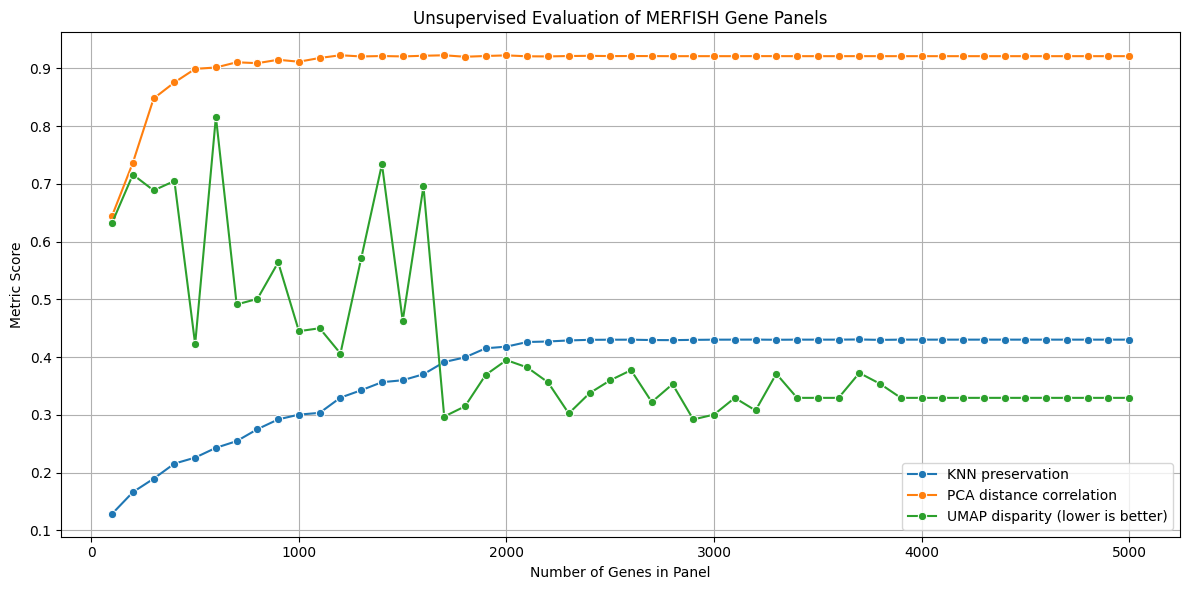

In [8]:
# Plotting
df = pd.DataFrame(results)

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="panel_size", y="knn_preservation", marker="o", label="KNN preservation")
sns.lineplot(data=df, x="panel_size", y="distance_corr", marker="o", label="PCA distance correlation")
sns.lineplot(data=df, x="panel_size", y="umap_disparity", marker="o", label="UMAP disparity (lower is better)")
plt.xlabel("Number of Genes in Panel")
plt.ylabel("Metric Score")
plt.title("Unsupervised Evaluation of MERFISH Gene Panels")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()